Advecting (c=-1): 100%|██████████| 2999/2999 [00:00<00:00, 159071.24it/s]


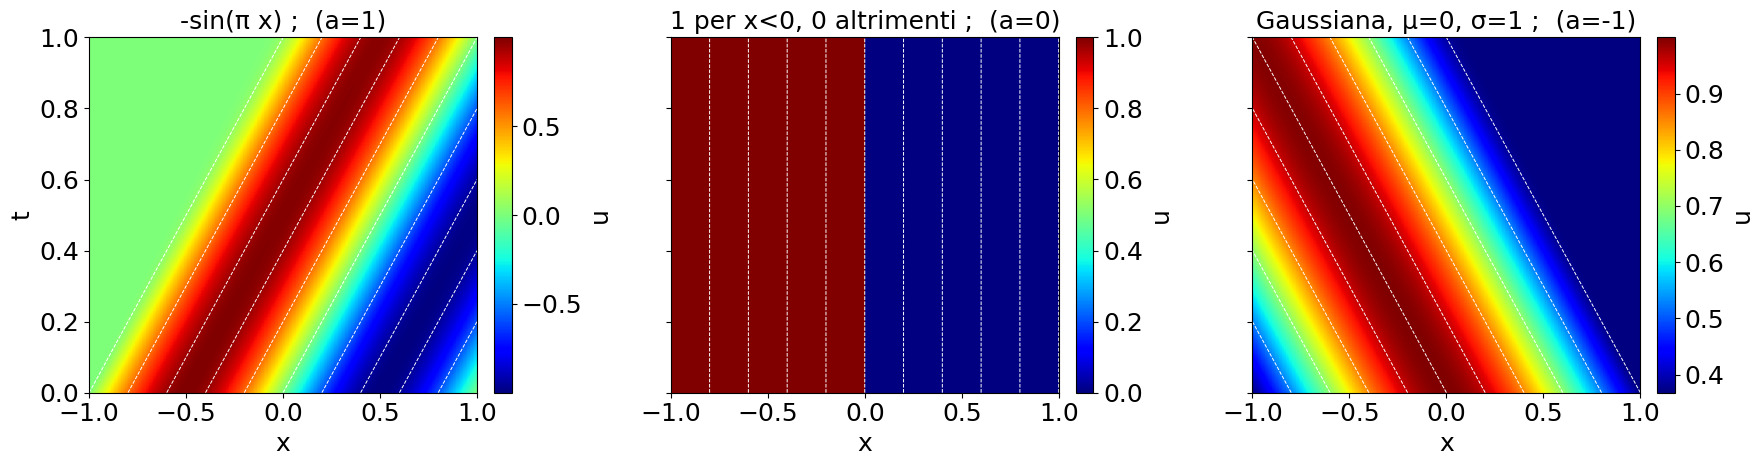

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

x = np.linspace(-1, 1, 1000)  # dummy x for initial conditions
plt.rcParams.update({
    'font.size':        18,
    'axes.titlesize':   18,
    'axes.labelsize':   18,
    'xtick.labelsize':  18,
    'ytick.labelsize':  18,
    'legend.fontsize':  18,
})

# 1) Solver ---------------------------------------------------------------
def linear_advection(u0, c=1.0, L=2.0, T=1.0, nx=400, nt=400):
    dx = L/(nx-1)
    dt = T/(nt-1)
    x = np.linspace(-L/2, L/2, nx)
    u = u0(x).copy()
    u_hist = np.empty((nt, nx))
    u_hist[0] = u

    for n in tqdm(range(1, nt), desc=f"Advecting (c={c})"):
        un = u.copy()
        if c > 0:
            # upwind (backward diff) for positive c
            u[1:] = un[1:] - c*(dt/dx)*(un[1:] - un[:-1])
            u[0]  = un[0]
        elif c < 0:
            # upwind (forward diff) for negative c
            u[:-1] = un[:-1] - c*(dt/dx)*(un[1:] - un[:-1])
            u[-1]  = un[-1]
        else:
            # c=0 -> no change
            u[:] = un
        u_hist[n] = u

    t = np.linspace(0, T, nt)
    return x, t, u_hist

# 2) IC generators --------------------------------------------------------
def sine_ic(x):
    return -np.sin(np.pi * x)

def riemann_ic(x):
    return np.where(x < 0, 1.0, 0.0)

def gaussian_ic(x):
    return np.exp(-x**2)

# 3) Plot all three in one row with individual colorbars -----------------
ic_list = [
    ("-sin(π x)",           sine_ic),
    ("1 per x<0, 0 altrimenti", riemann_ic),
    ("Gaussiana, μ=0, σ=1",  gaussian_ic),
]
speeds = [1, 0, -1]    # one speed per IC

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

for ax, (title, u0), c in zip(axes, ic_list, speeds):
    max_all = np.max(u0(x))
    min_all = np.min(u0(x))
    x, t, U = linear_advection(u0, c=c, nx=500, nt=3000)
    X, TT = np.meshgrid(x, t)

    pcm = ax.pcolormesh(X, TT, U, cmap='jet',
                          shading='auto', vmin=min_all, vmax=max_all)

    ax.set_title(f"{title} ;  (a={c})")
    ax.set_xlabel('x')
    ax.set_xlim(x[0], x[-1])
    if ax is axes[0]:
        ax.set_ylabel('t')

    # overlay clipped characteristics
    x_min, x_max = x[0], x[-1]
    x0s = np.linspace(x_min, x_max, 11)
    for x0 in x0s:
        x_char = x0 + c*t
        mask = (x_char >= x_min) & (x_char <= x_max)
        ax.plot(x_char[mask], t[mask], 'w--', linewidth=0.7)

    # individual colorbar
    fig.colorbar(pcm, ax=ax, orientation='vertical',
                 fraction=0.046, pad=0.04, label='u')

plt.tight_layout()
plt.show()


LF Burgers: 100%|██████████| 399/399 [00:00<00:00, 91906.60it/s]


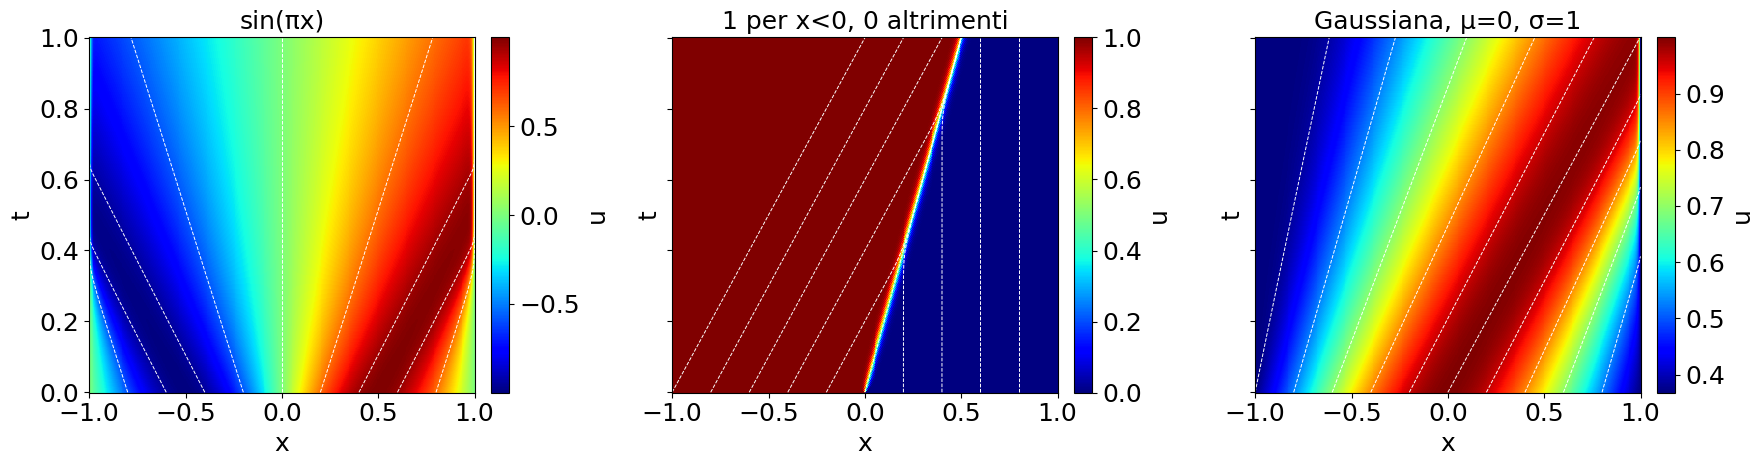

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
plt.rcParams.update({
    'font.size':        18,
    'axes.titlesize':   18,
    'axes.labelsize':   18,
    'xtick.labelsize':  18,
    'ytick.labelsize':  18,
    'legend.fontsize':  18,
})
# ——— Burgers solver with Lax–Friedrichs ————————————————————————
def burgers_lax_friedrichs(u0, L=2.0, T=1.0, nx=400, nt=400):
    dx = L/(nx-1)
    dt = T/(nt-1)
    x  = np.linspace(-L/2, L/2, nx)
    u  = u0(x).copy()
    Uh = np.empty((nt, nx))
    Uh[0] = u

    for n in tqdm(range(1, nt), desc="LF Burgers"):
        un   = u.copy()
        flux = 0.5 * un**2
        # interior update
        u[1:-1] = 0.5*(un[2:] + un[:-2]) \
                - (dt/(2*dx))*(flux[2:] - flux[:-2])
        # zero‐gradient BCs
        u[0]    = un[0]
        u[-1]   = un[-1]
        Uh[n]   = u

    t = np.linspace(0, T, nt)
    return x, t, Uh

# ——— ICs ————————————————————————————————————————————————
def sine_ic(x):
    return np.sin(np.pi * x)

def riemann_ic(x):
    return np.where(x < 0, 1.0, 0.0)

def gaussian_ic(x):
    return np.exp(-x**2)

# ——— Plot + characteristics —————————————————————————————————
def plot_burgers(x, t, U, ax, title):
    X, TT = np.meshgrid(x, t)
    pcm = ax.pcolormesh(X, TT, U, cmap='jet', shading='auto')
    ax.set_title(title)
    ax.set_xlabel('x')
    ax.set_xlim(x[0], x[-1])
    ax.set_ylabel('t')

    # integrate characteristics dx/dt = u
    nc  = 11
    x0  = np.linspace(x[0], x[-1], nc)
    char = np.zeros((nc, len(t)))
    char[:,0] = x0
    dt = t[1] - t[0]

    for n in range(len(t)-1):
        u_at_char = np.interp(char[:,n], x, U[n])
        char[:,n+1] = char[:,n] + u_at_char * dt

    # only plot portions inside domain
    for i in range(nc):
        mask = (char[i] >= x[0]) & (char[i] <= x[-1])
        ax.plot(char[i,mask], t[mask], 'w--', lw=0.7)

    return pcm

# ——— main ——————————————————————————————————————————————
ic_list = [
    ("sin(πx)",           sine_ic),
    ("1 per x<0, 0 altrimenti", riemann_ic),
    ("Gaussiana, μ=0, σ=1",  gaussian_ic),
]

fig, axes = plt.subplots(1, 3, figsize=(18,5), sharey=True)

# compute each and plot with its own colorbar
for ax, (title, ic) in zip(axes, ic_list):
    x, t, U = burgers_lax_friedrichs(ic, nx=400, nt=400)
    pcm = plot_burgers(x, t, U, ax, title)
    # individual colorbar for this subplot
    fig.colorbar(pcm, ax=ax, orientation='vertical',
                 fraction=0.046, pad=0.04, label='u')

plt.tight_layout()
plt.show()


LF Burgers:   0%|          | 0/399 [00:00<?, ?it/s]

LF Burgers: 100%|██████████| 399/399 [00:00<?, ?it/s]


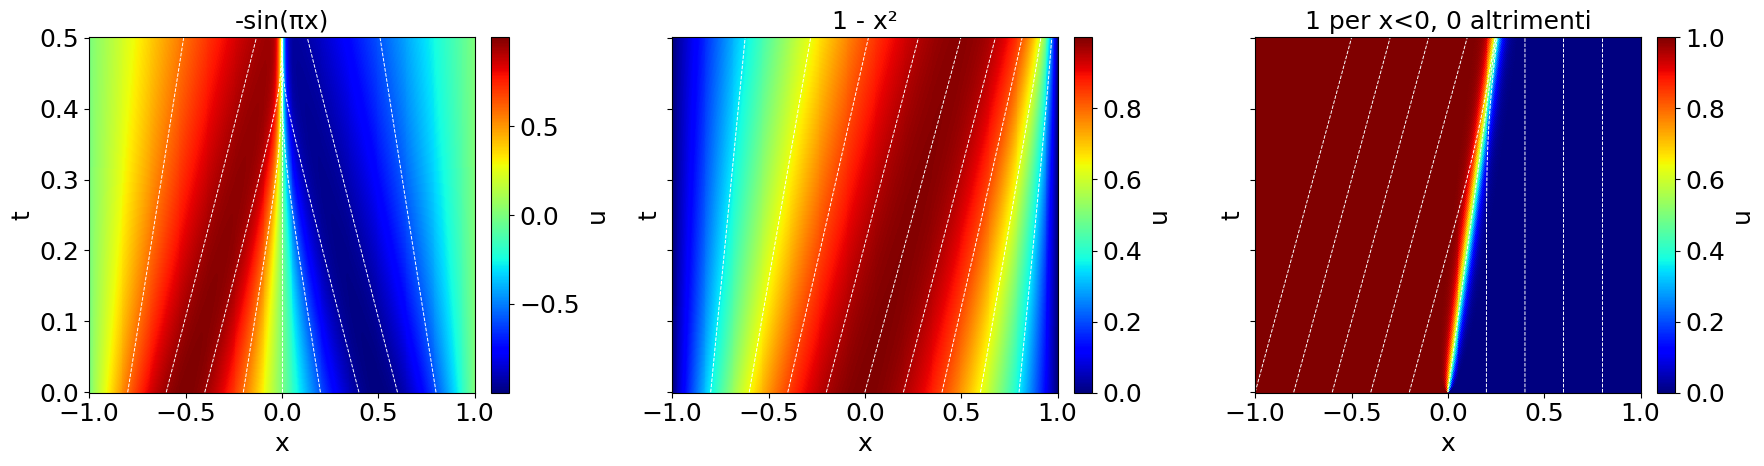

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
plt.rcParams.update({
    'font.size':        18,
    'axes.titlesize':   18,
    'axes.labelsize':   18,
    'xtick.labelsize':  18,
    'ytick.labelsize':  18,
    'legend.fontsize':  18,
})
# ——— Burgers solver with Lax–Friedrichs ————————————————————————
def burgers_lax_friedrichs(u0, L=2.0, T=0.5, nx=400, nt=400):
    dx = L/(nx-1)
    dt = T/(nt-1)
    x  = np.linspace(-L/2, L/2, nx)
    u  = u0(x).copy()
    Uh = np.empty((nt, nx))
    Uh[0] = u

    for n in tqdm(range(1, nt), desc="LF Burgers"):
        un   = u.copy()
        flux = 0.5 * un**2
        # interior update
        u[1:-1] = 0.5*(un[2:] + un[:-2]) \
                - (dt/(2*dx))*(flux[2:] - flux[:-2])
        # zero‐gradient BCs
        u[0]    = un[0]
        u[-1]   = un[-1]
        Uh[n]   = u

    t = np.linspace(0, T, nt)
    return x, t, Uh

# ——— Shock-producing initial conditions ———————————————————————

def neg_sin_ic(x):
    """Negative sine: u(x) = -sin(pi x), shocks form where slope is negative."""
    return -np.sin(np.pi * x)


def parabolic_hump(x, width=1.0):
    """Parabolic hump: u(x) = max(1 - (x/width)^2, 0), shocks at edges."""
    return np.where(np.abs(x) < width, 1 - (x/width)**2, 0.0)


def riemann_shock(x, uL=1.0, uR=0.0):
    """Step with u_L > u_R forms a single shock at x=0."""
    return np.where(x < 0, uL, uR)

# ——— Plot + characteristics —————————————————————————————————
def plot_burgers(x, t, U, ax, title):
    X, TT = np.meshgrid(x, t)
    pcm = ax.pcolormesh(X, TT, U, cmap='jet', shading='auto')
    ax.set_title(title)
    ax.set_xlabel('x')
    ax.set_xlim(x[0], x[-1])
    ax.set_ylabel('t')

    # integrate characteristics dx/dt = u
    nc  = 11
    x0  = np.linspace(x[0], x[-1], nc)
    char = np.zeros((nc, len(t)))
    char[:,0] = x0
    dt = t[1] - t[0]

    for n in range(len(t)-1):
        u_at_char = np.interp(char[:,n], x, U[n])
        char[:,n+1] = char[:,n] + u_at_char * dt

    for i in range(nc):
        mask = (char[i] >= x[0]) & (char[i] <= x[-1])
        ax.plot(char[i,mask], t[mask], 'w--', lw=0.7)

    return pcm

# ——— main: simulate and plot three shock ICs —————————————————————
ic_list = [
    ("-sin(πx)",   neg_sin_ic),
    ("1 - x²",     parabolic_hump),
    ("1 per x<0, 0 altrimenti",    riemann_shock),
]

fig, axes = plt.subplots(1, 3, figsize=(18,5), sharey=True)
for ax, (title, ic) in zip(axes, ic_list):
    x, t, U = burgers_lax_friedrichs(ic)
    pcm = plot_burgers(x, t, U, ax, title)
    fig.colorbar(pcm, ax=ax, orientation='vertical', fraction=0.046, pad=0.04, label='u')

plt.tight_layout()
plt.show()


LF Burgers:   0%|          | 0/1999 [00:00<?, ?it/s]

LF Burgers: 100%|██████████| 1999/1999 [00:00<00:00, 21260.16it/s]


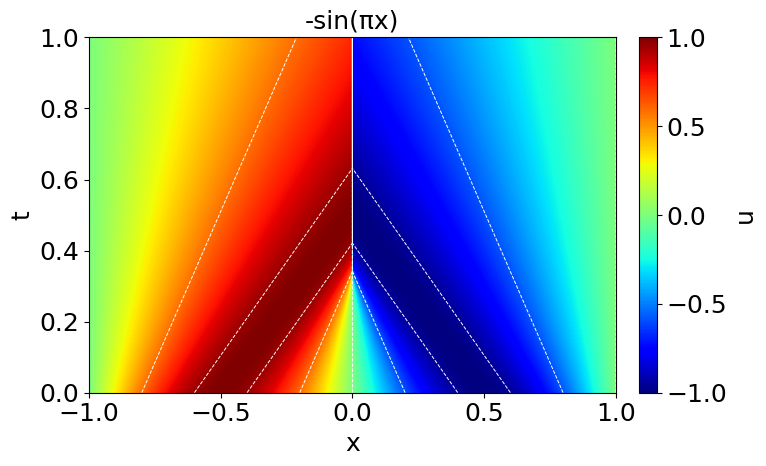

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

plt.rcParams.update({
    'font.size':        18,
    'axes.titlesize':   18,
    'axes.labelsize':   18,
    'xtick.labelsize':  18,
    'ytick.labelsize':  18,
    'legend.fontsize':  18,
})

# ——— Burgers solver with Lax–Friedrichs ————————————————————————
def burgers_lax_friedrichs(u0, L=2.0, T=0.5, nx=400, nt=400):
    dx = L/(nx-1)
    dt = T/(nt-1)
    x  = np.linspace(-L/2, L/2, nx)
    u  = u0(x).copy()
    Uh = np.empty((nt, nx))
    Uh[0] = u

    for n in tqdm(range(1, nt), desc="LF Burgers"):
        un   = u.copy()
        flux = 0.5 * un**2
        # interior update
        u[1:-1] = 0.5*(un[2:] + un[:-2]) \
                - (dt/(2*dx))*(flux[2:] - flux[:-2])
        # zero‐gradient BCs
        u[0]    = un[0]
        u[-1]   = un[-1]
        Uh[n]   = u

    t = np.linspace(0, T, nt)
    return x, t, Uh

# ——— Sine initial condition ——————————————————————————————————
def sine_ic(x):
    """Sine wave: u(x) = sin(pi x). Steepening until shock forms."""
    return -np.sin(np.pi * x)

# ——— Plot + characteristics —————————————————————————————————
def plot_burgers(x, t, U, ax, title):
    X, TT = np.meshgrid(x, t)
    pcm = ax.pcolormesh(X, TT, U, cmap='jet', shading='auto')
    ax.set_title(title)
    ax.set_xlabel('x')
    ax.set_xlim(x[0], x[-1])
    ax.set_ylabel('t')

    # integrate characteristics dx/dt = u
    nc  = 11
    x0  = np.linspace(x[0], x[-1], nc)
    char = np.zeros((nc, len(t)))
    char[:,0] = x0
    dt = t[1] - t[0]

    for n in range(len(t)-1):
        u_at_char = np.interp(char[:,n], x, U[n])
        char[:,n+1] = char[:,n] + u_at_char * dt

    for i in range(nc):
        mask = (char[i] >= x[0]) & (char[i] <= x[-1])
        ax.plot(char[i,mask], t[mask], 'w--', lw=0.7)

    return pcm

# ——— main: simulate and plot sine IC ————————————————————————————

# Compute solution
x, t, U = burgers_lax_friedrichs(sine_ic, L=2.0, T=1, nx=4000, nt=2000)

# Plot
fig, ax = plt.subplots(figsize=(8,5))
pc = plot_burgers(x, t, U, ax, '-sin(πx)')
fig.colorbar(pc, ax=ax, orientation='vertical', fraction=0.046, pad=0.04, label='u')
plt.tight_layout()
plt.show()


Shock formation time Tb = 0.318310


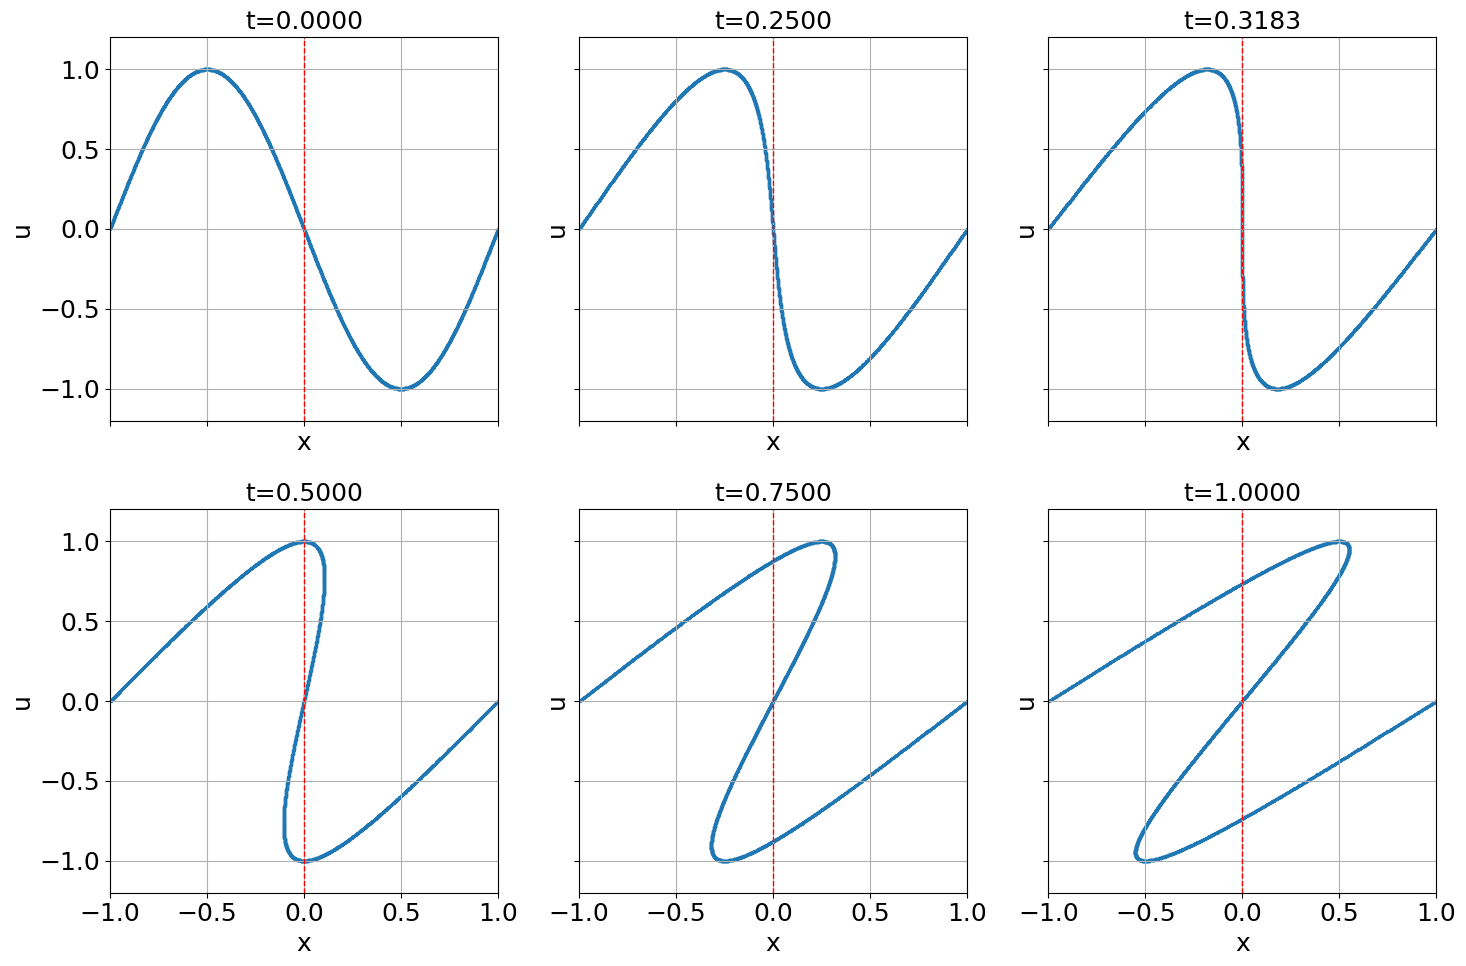

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# ——— Initial condition u0(x) = -sin(pi x) and shock time calculation —————————————————
plt.rcParams.update({
    'font.size':        18,
    'axes.titlesize':   18,
    'axes.labelsize':   18,
    'xtick.labelsize':  18,
    'ytick.labelsize':  18,
    'legend.fontsize':  18,
})
# define u0 and its derivative
u0 = lambda x: -np.sin(np.pi * x)
du0 = lambda x: -np.pi * np.cos(np.pi * x)

# compute minimum slope and shock formation time Tb
xi = np.linspace(-1, 1, 10001)
slope_vals = du0(xi)
min_slope = np.min(slope_vals)
tb = -1.0 / min_slope
print(f"Shock formation time Tb = {tb:.6f}")

# ——— Analytical multi-valued characteristic tracing ————————————————————————
def multi_valued_solution(u0, xi_min=-1.0, xi_max=1.0, nxi=2000, t=0.0):
    xi = np.linspace(xi_min, xi_max, nxi)
    U = u0(xi)
    X = xi + U * t
    return X, U

# ——— prepare time snapshots ——————————————————————————————————————————
# include t=0, linspace from 0 to 1 (excluding 0), plus Tb
t_lin = np.linspace(0, 1, 5)[1:]   # [0.25, 0.5, 0.75, 1.0]
times = np.hstack(([0.0], t_lin, [tb]))
times = np.sort(times)
labels = [f"t={t:.4f}" for t in times]

# ——— plot in 2x3 grid ——————————————————————————————————————————————
fig, axes = plt.subplots(2, 3, figsize=(15, 10), sharex=True, sharey=True)
axes = axes.flatten()
for ax, t, label in zip(axes, times, labels):
    X, U = multi_valued_solution(u0, t=t)
    ax.scatter(X, U, s=2)
    ax.axvline(0.0, color='red', linestyle='--', linewidth=1)
    ax.set_title(label)
    ax.set_xlabel('x')
    ax.set_ylabel('u')
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1.2, 1.2)
    ax.grid(True)

plt.tight_layout()
plt.show()


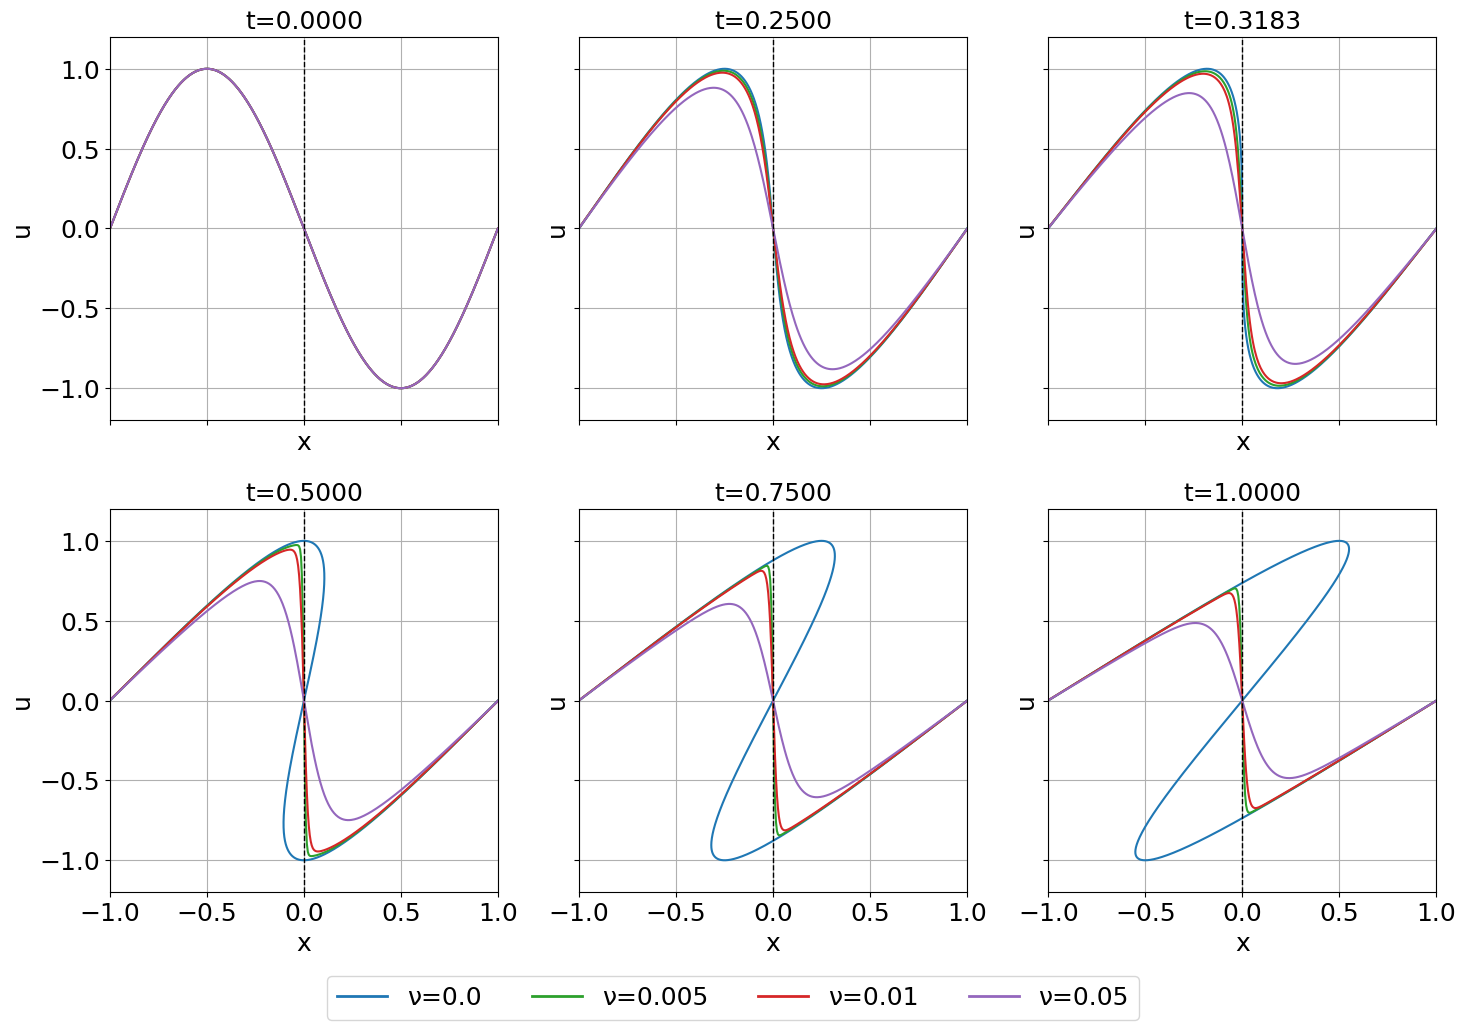

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import matplotlib.lines as mlines

# Imposto font grandi globali
plt.rcParams.update({
    'font.size':        18,
    'axes.titlesize':   18,
    'axes.labelsize':   18,
    'xtick.labelsize':  18,
    'ytick.labelsize':  18,
    'legend.fontsize':  18,
})

# Initial condition
u0 = lambda x: -np.sin(np.pi * x)

# Inviscid multi‐valued solution
def multi_valued_solution(u0, xi_min=-1.0, xi_max=1.0, nxi=2000, t=0.0):
    xi = np.linspace(xi_min, xi_max, nxi)
    U  = u0(xi)
    X  = xi + U * t
    return X, U

# Viscous Burgers solver
def solve_burgers(nu, u0, nx=401, T=0.5, dt=2e-4):
    x  = np.linspace(-1, 1, nx)
    u  = u0(x)
    dx = x[1] - x[0]
    nt = int(T / dt)
    for _ in range(max(nt, 0)):
        un = u.copy()
        u_x  = (np.roll(un, -1) - np.roll(un, 1)) / (2 * dx)
        u_xx = (np.roll(un, -1) - 2*un + np.roll(un, 1)) / dx**2
        u    = un + dt * (-un * u_x + nu * u_xx)
    return x, u

# Calcolo tempo di formazione dello shock
du0 = lambda x: -np.pi * np.cos(np.pi * x)
xi  = np.linspace(-1, 1, 10001)
tb  = -1.0 / np.min(du0(xi))

# Istanti temporali e valori di nu
t_lin    = np.linspace(0, 1, 5)[1:]          # [0.25, 0.5, 0.75, 1.0]
times    = np.sort(np.hstack(([0.0], t_lin, [tb])))
labels   = [f"t={t:.4f}" for t in times]

nu_values = [0.0, 0.005, 0.01, 0.05]
# Colori prestabiliti
color_map = {
    0.0:   'tab:blue',
    0.005: 'tab:green',
    0.01:  'tab:red',
    0.05:  'tab:purple'
}

# Plotting
fig, axes = plt.subplots(2, 3, figsize=(15, 10), sharex=True, sharey=True)
axes = axes.flatten()

for ax, t, title in zip(axes, times, labels):
    for nu in nu_values:
        col = color_map[nu]
        if nu == 0.0:
            X, U = multi_valued_solution(u0, t=t)
            # ora tracciamo una linea invece di punti
            ax.plot(X, U, linestyle='-', linewidth=1.5, color=col)
        else:
            x_visc, u_visc = solve_burgers(nu, u0, T=t)
            ax.plot(x_visc, u_visc, color=col, linewidth=1.5)

    ax.axvline(0, color='k', linestyle='--', linewidth=1)
    ax.set_title(title)
    ax.set_xlabel('x')
    ax.set_ylabel('u')
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1.2, 1.2)
    ax.grid(True)

# Creo proxy artist per legenda unica (tutti come linee)
proxies = []
labels = []
for nu in nu_values:
    col = color_map[nu]
    p = mlines.Line2D([], [], color=col, linewidth=2, label=f'ν={nu}')
    proxies.append(p)
    labels.append(f'ν={nu}')

# Spazio extra in basso
fig.subplots_adjust(bottom=0.20)

# Legenda unica molto in basso
fig.legend(proxies, labels,
           loc='lower center', ncol=len(nu_values),
           bbox_to_anchor=(0.5, -0.05))

plt.tight_layout()
plt.show()
